## Author: Akash

### Studying gentrification in cities based on redlining and rental indices

Data Source: Redlining Index (Uni. of Richmond), Rental Prioritisation Index (Urban Institute)

In [ ]:
#Loading needed libraries
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import fiona
from shapely.geometry import shape, mapping
import rtree
import fiona.crs
from libpysal.weights.contiguity import Queen
from libpysal import examples
import numpy as np
import os
import splot
import pysal
from libpysal import weights
import esda
from esda.moran import Moran, Moran_Local,Moran_BV, Moran_Local_BV
from splot.esda import lisa_cluster, plot_moran_bv_simulation, plot_moran_bv, plot_local_autocorrelation, moran_scatterplot

In [ ]:
#Reading the rent prioritisation data made available by the Urban Institute 
rent_data = gpd.read_file('/datasets/rent_prioritisation/housing_index_state_adj.geojson')

In [ ]:
#Reading the redlined data
geo_files = [
"/home/jovyan/work/COVIDRedlining/data/dallas/dallas_redlined_numerical_values.geojson",
"/home/jovyan/work/COVIDRedlining/data/detroit/detroit_redlined_numerical_values.geojson",
"/home/jovyan/work/COVIDRedlining/data/new york/ny_redlined_numerical_values.geojson",
"/home/jovyan/work/COVIDRedlining/data/minneapolis/minneapolis_redlined_numerical_values.geojson",
"/home/jovyan/work/COVIDRedlining/data/california/cali_redlined_numerical_values.geojson",
"/home/jovyan/work/COVIDRedlining/data/boston/boston_redlined_numerical_values.geojson",
"/home/jovyan/work/COVIDRedlining/data/tampa/tampa_redlined_numerical_values.geojson",
"/home/jovyan/work/COVIDRedlining/data/newark/newark_redlined_numerical_values.geojson",
"/home/jovyan/work/COVIDRedlining/data/chicago/chicago_redlined_numerical_values.geojson",
"/home/jovyan/work/COVIDRedlining/data/atlanta/atlanta_redlined_numerical_values.geojson",
"/home/jovyan/work/COVIDRedlining/data/houston/houston_redlined_numerical_values.geojson",
"/home/jovyan/work/COVIDRedlining/data/nashville/nashville_redlined_numerical_values.geojson",
"/home/jovyan/work/COVIDRedlining/data/stlouis/stlouis_redlined_numerical_values.geojson"
]

dfs = [gpd.read_file(x) for x in geo_files]

In [ ]:
#Combining all geo-files together and rounding the reweighted redline index to 2 decimal values
geo_intersect = pd.DataFrame(pd.concat(dfs))
geo_intersect['reweighted_redline_index'] = geo_intersect['reweighted_redline_index'].round(2)
geo_intersect.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,reweighted_redline_index,ordinal_value,geometry
0,48,113,980100,4.811398e+10,9801,Census Tract 9801,G5020,S,5493433,0,+32.8455619,-096.8494250,3.10,4,"POLYGON ((-96.86907 32.84576, -96.86893 32.846..."
1,48,113,000605,4.811300e+10,6.05,Census Tract 6.05,G5020,S,537957,0,+32.8104817,-096.8071671,2.09,3,"POLYGON ((-96.81350 32.81280, -96.81263 32.813..."
2,48,113,007101,4.811301e+10,71.01,Census Tract 71.01,G5020,S,1180246,0,+32.8443119,-096.8175334,1.00,1,"POLYGON ((-96.82198 32.83702, -96.82187 32.837..."
3,48,113,004201,4.811300e+10,42.01,Census Tract 42.01,G5020,S,2569176,9714,+32.7584519,-096.8299088,2.16,3,"POLYGON ((-96.83757 32.75015, -96.83756 32.750..."
4,48,113,005901,4.811301e+10,59.01,Census Tract 59.01,G5020,S,2898961,0,+32.6930920,-096.8082157,3.00,3,"POLYGON ((-96.81470 32.69375, -96.81467 32.695..."


In [ ]:
#Merging geofiles with the rental prioritisation index data
rent_data['GEOID'] = rent_data['GEOID'].astype(float)
rent_redline_data = geo_intersect.merge(rent_data,on='GEOID',how='left',suffixes=('_redline','_rent'))
rent_redline_data.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,z_score_perc_poverty_12mnth_quantile,z_score_perc_no_hinsure_quantile,z_score_perc_person_of_color_quantile,z_score_perc_public_assistance_quantile,z_score_perc_foreign_born_quantile,z_score_perc_30hamfi_quantile,z_score_perc_low_income_jobs_lost_quantile,num_ELI,grayed_out,geometry_rent
0,48,113,980100,4.811398e+10,9801,Census Tract 9801,G5020,S,5493433,0,...,0.01,0.01,0.99,0.17,0.97,0.05,0.91,0.0,1.0,"MULTIPOLYGON (((-96.86607 32.84849, -96.86446 ..."
1,48,113,000605,4.811300e+10,6.05,Census Tract 6.05,G5020,S,537957,0,...,0.19,0.07,0.19,0.26,0.67,0.48,0.88,170.0,0.0,"MULTIPOLYGON (((-96.81350 32.81280, -96.80998 ..."
2,48,113,007101,4.811301e+10,71.01,Census Tract 71.01,G5020,S,1180246,0,...,0.39,0.02,0.07,0.41,0.55,0.26,0.86,60.0,0.0,"MULTIPOLYGON (((-96.82185 32.83737, -96.82160 ..."
3,48,113,004201,4.811300e+10,42.01,Census Tract 42.01,G5020,S,2569176,9714,...,0.62,0.53,0.62,0.53,0.63,0.51,0.67,160.0,0.0,"MULTIPOLYGON (((-96.83745 32.75238, -96.83746 ..."
4,48,113,005901,4.811301e+10,59.01,Census Tract 59.01,G5020,S,2898961,0,...,0.79,0.59,0.92,0.91,0.50,0.88,0.48,265.0,0.0,"MULTIPOLYGON (((-96.81463 32.70297, -96.81458 ..."


In [ ]:
#Subsetting the data for running correlations
corr_data = rent_redline_data[['GEOID','state_name','county_name','total_index_quantile','perc_person_of_color','ordinal_value']]
corr_data.head()

,GEOID,state_name,county_name,total_index_quantile,perc_person_of_color,ordinal_value
0,4.811398e+10,Texas,Dallas County,0.54,1.000000,4
1,4.811300e+10,Texas,Dallas County,0.37,0.269623,3
2,4.811301e+10,Texas,Dallas County,0.21,0.158301,1
3,4.811300e+10,Texas,Dallas County,0.67,0.687595,3
4,4.811301e+10,Texas,Dallas County,0.81,0.965158,3


In [ ]:
#Subsetting the data to only include the 14 cities under study
states = ['New York','California','Illinois','Michigan','Missouri','Texas','Georgia','Tennessee','Massachusetts','New Jersey','Minnesota','Florida']
counties = ['Kings County','Richmond County', 'Bronx County', ' Queens County', 'New York County',
'Los Angeles County','San Francisco County','Cook County','Wayne County','St. Louis County','Harris County',
'Dallas County','Fulton County','Davidson County','Suffolk County','Essex County','Hennepin County','Hillsborough County']
corr_data = corr_data[corr_data['state_name'].isin(states)]
corr_data = corr_data[corr_data['county_name'].isin(counties)]
corr_data.shape

(5574, 6)

In [ ]:
#Assigning a new column having the city name against each census tract
def city_name(row):
    if row['county_name'] == 'Kings County':
      val = 'New York'
    elif row['county_name'] == 'Richmond County':
      val = 'New York'
    elif row['county_name'] == 'Bronx County':
      val = 'New York'
    elif row['county_name'] == ' Queens County':
      val = 'New York'
    elif row['county_name'] == 'New York County':
      val = 'New York'
    elif row['county_name'] == 'Los Angeles County':
      val = 'Los Angeles'
    elif row['county_name'] == 'San Francisco County':
      val = 'San Francisco'
    elif row['county_name'] == 'Cook County':
      val = 'Chicago'
    elif row['county_name'] == 'Wayne County':
      val = 'Detroit'
    elif row['county_name'] == 'St. Louis County':
      val = 'St. Louis'
    elif row['county_name'] == 'Harris County':
      val = 'Houston'
    elif row['county_name'] == 'Dallas County':
      val = 'Dallas' 
    elif row['county_name'] == 'Fulton County':
      val = 'Atlanta'
    elif row['county_name'] == 'Davidson County':
      val = 'Nashville' 
    elif row['county_name'] == 'Suffolk County' and row['state_name'] == 'Massachusetts':
      val = 'Boston'
    elif row['county_name'] == 'Essex County':
      val = 'Newark'
    elif row['county_name'] == 'Hennepin County':
      val = 'Minneapolis' 
    elif row['county_name'] == 'Hillsborough County':
      val = 'Tampa' 
    else:
      val = 0

    return val

corr_data['city_name'] = corr_data.apply(city_name, axis=1)

In [ ]:
#Joining with correlation data
rent_data['GEOID'] = rent_data['GEOID'].astype(float)
spatial_corr_data = rent_data[['GEOID','geometry']].merge(corr_data,on='GEOID',how='right')
spatial_corr_data.head()

,GEOID,geometry,state_name,county_name,total_index_quantile,perc_person_of_color,ordinal_value,city_name
0,6.037550e+09,"MULTIPOLYGON (((-118.11354 33.95430, -118.1116...",California,Los Angeles County,0.49,0.823853,3,Los Angeles
1,6.037551e+09,"MULTIPOLYGON (((-118.12323 33.93708, -118.1218...",California,Los Angeles County,0.47,0.802353,2,Los Angeles
2,6.037603e+09,"MULTIPOLYGON (((-118.29978 33.88015, -118.2997...",California,Los Angeles County,0.71,0.900321,4,Los Angeles
3,6.037603e+09,"MULTIPOLYGON (((-118.31348 33.88706, -118.3134...",California,Los Angeles County,0.68,0.906136,4,Los Angeles
4,6.037603e+09,"MULTIPOLYGON (((-118.31349 33.88195, -118.3091...",California,Los Angeles County,0.73,0.887410,4,Los Angeles


### Exploring Gentrification in Boston

In [ ]:
boston_counties = ['Suffolk County']

boston = spatial_corr_data[(spatial_corr_data['county_name'].isin(boston_counties))&(spatial_corr_data['state_name']=='Massachusetts')]

boston = boston.dropna()

y = boston['total_index_quantile'].values
w = Queen.from_dataframe(boston)
w.transform = 'R'
x = boston['ordinal_value'].values
moran = Moran(y,w)
moran_loc = Moran_Local(y, w)
moran_bv = Moran_BV(y, x, w)
moran_loc_bv = Moran_Local_BV(y, x, w)
moran_bv.I

0.06343628545065509

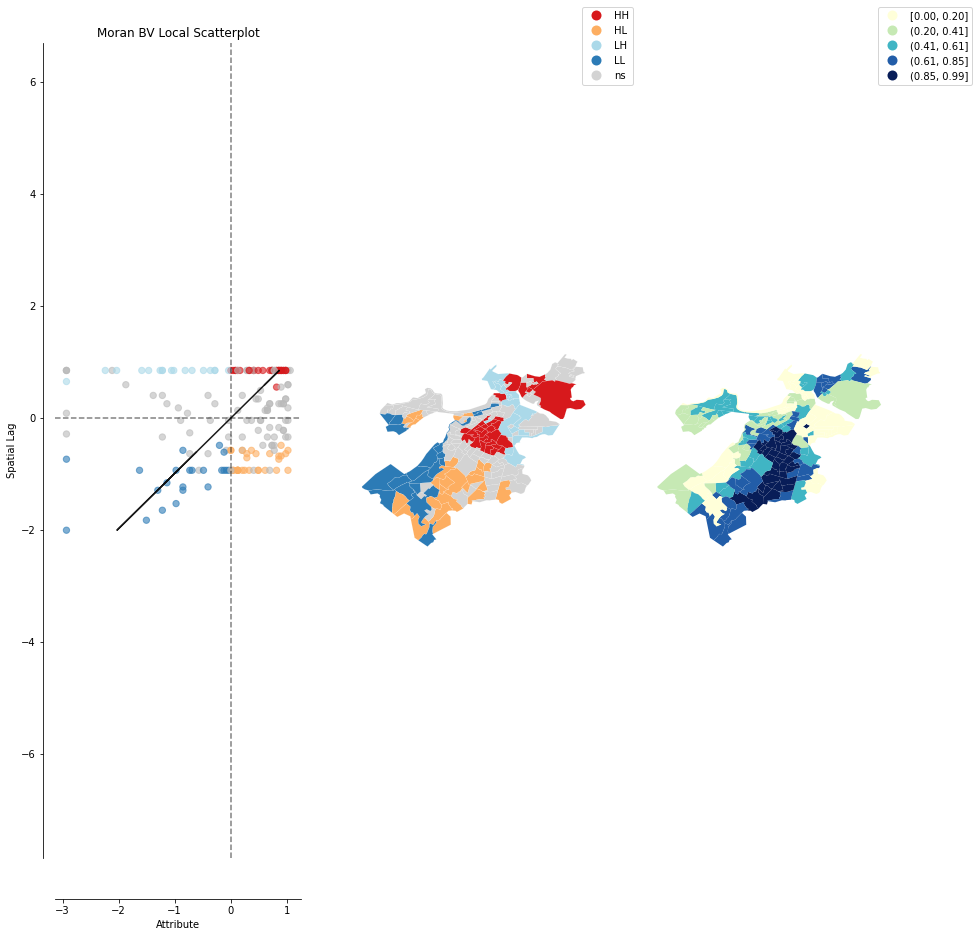

In [ ]:
#Plotting Local Autocorrelations for bivariate relationship between tests done between October and September against cases confirmed in October
plot_local_autocorrelation(moran_loc_bv, boston, 'perc_person_of_color', figsize=(15,15))
plt.show()

In [ ]:
!pip install googlemaps

  Created wheel for googlemaps: filename=googlemaps-4.4.2-py3-none-any.whl size=37858 sha256=3a3d6c04c4468982217d061751a73b7752abb9c77277b683bf15f7e7c94254ed
  Stored in directory: /tmp/pip-ephem-wheel-cache-ojn4js1e/wheels/7e/30/c7/07c30ff7be3c000ed5f8b2aad1083c8697a2afde133f58b5ca
Successfully built googlemaps
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
#Writing a function to get neighborhood names from latitude and longitude
from urllib.request import urlopen
import json
import requests

locality = None
town = None

def getplace(lat, lon):
    key = ""
    url = "https://maps.googleapis.com/maps/api/geocode/json?"
    url += "latlng=%s,%s&sensor=false&key=%s" % (lat, lon, key)
    r = requests.get(url)
    if r.status_code not in range(200, 299):
        return None
        
    try:
        i = 0
        v = urlopen(url).read()
        j = json.loads(v)
        components = j['results'][0]['address_components']
        country = town = None
        for c in components:
            global locality
            if "route" in c['types']:
                locality = c['long_name']
                print(locality)
    except:
        pass
    return locality

In [ ]:
#Creating lat-long values
boston['lon'] = boston.center.x
boston['lat'] = boston.center.y

In [ ]:
#Applying function to the dataframe
boston['geom'] = boston['lat'].map(str) + ',' + boston['lon'].map(str)
boston[['locality']] = boston.apply(lambda x: getplace(x['lat'],x['lon']), axis=1)

In [ ]:
boston.head()

,GEOID,geometry,state_name,county_name,total_index_quantile,perc_person_of_color,ordinal_value,city_name,center,lon,lat,geom,locality
2824,2.502506e+10,"MULTIPOLYGON (((-71.04776 42.33681, -71.04556 ...",Massachusetts,Suffolk County,0.27,0.086220,4,Boston,POINT (-71.03822 42.33687),-71.038218,42.336867,"42.33686742377814,-71.03821842220876",East 2nd Street
2825,2.502506e+10,"MULTIPOLYGON (((-71.05693 42.32855, -71.05262 ...",Massachusetts,Suffolk County,0.99,0.822609,4,Boston,POINT (-71.05430 42.32620),-71.054302,42.326197,"42.32619660626351,-71.05430236771505",Gavin Way
2826,2.502507e+10,"MULTIPOLYGON (((-71.06423 42.35339, -71.06331 ...",Massachusetts,Suffolk County,0.84,0.474770,4,Boston,POINT (-71.05726 42.35243),-71.057263,42.352428,"42.35242777723553,-71.05726253244907",South Street
2827,2.502507e+10,"MULTIPOLYGON (((-71.06850 42.34760, -71.06819 ...",Massachusetts,Suffolk County,0.94,0.701835,4,Boston,POINT (-71.06484 42.34542),-71.064845,42.345421,"42.34542127738507,-71.06484475630931",Washington Street
2828,2.502507e+10,"MULTIPOLYGON (((-71.07694 42.33653, -71.07500 ...",Massachusetts,Suffolk County,0.83,0.521678,4,Boston,POINT (-71.07267 42.33606),-71.072672,42.336055,"42.33605512070159,-71.07267244574471",East Concord Street


In [ ]:
#Creating points for label on maps
boston["center"] = boston["geometry"].centroid
boston_points = boston.copy()
boston_points.set_geometry("center", inplace = True)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


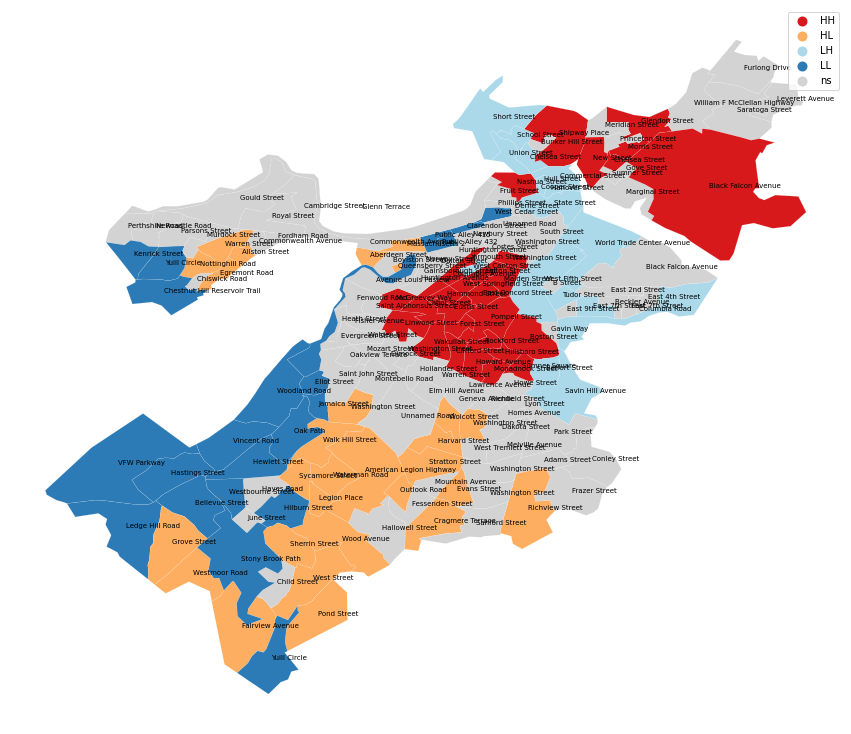

In [ ]:
#Visualising the clusters
texts = []

lisa_cluster(moran_loc_bv, boston, p=0.05, figsize = (15,15))
for x, y, label in zip(boston_points.geometry.x, boston_points.geometry.y, boston_points["locality"]):
    texts.append(plt.text(x, y, label, fontsize = 7))
plt.show()

In [ ]:
import folium

m = folium.Map(location=[42.3601, 71.0589], tiles="cartodbpositron", zoom_start=7)
folium.GeoJson(data=boston["geometry"]).add_to(m)
m

In [ ]:
#Getting cluster details - Possible Gentrified
boston['cluster'] = moran_loc_bv.q 
boston[boston['cluster']==2]

,GEOID,geometry,state_name,county_name,total_index_quantile,perc_person_of_color,ordinal_value,city_name,center,lon,lat,geom,locality,cluster
2824,2.502506e+10,"MULTIPOLYGON (((-71.04776 42.33681, -71.04556 ...",Massachusetts,Suffolk County,0.27,0.086220,4,Boston,POINT (-71.03822 42.33687),-71.038218,42.336867,"42.33686742377814,-71.03821842220876",East 2nd Street,2
2836,2.502506e+10,"MULTIPOLYGON (((-71.05238 42.33980, -71.04456 ...",Massachusetts,Suffolk County,0.42,0.184756,4,Boston,POINT (-71.04254 42.34939),-71.042539,42.349385,"42.349385316676965,-71.04253898384164",World Trade Center Avenue,2
2839,2.502503e+10,"MULTIPOLYGON (((-71.05853 42.36695, -71.05737 ...",Massachusetts,Suffolk County,0.47,0.116967,4,Boston,POINT (-71.05617 42.36687),-71.056168,42.366865,"42.36686500094658,-71.05616798622268",Hull Street,2
2843,2.502506e+10,"MULTIPOLYGON (((-71.03530 42.33229, -71.03326 ...",Massachusetts,Suffolk County,0.21,0.022658,3,Boston,POINT (-71.03282 42.33245),-71.032819,42.332448,"42.33244790964486,-71.03281860187084",East 7th Street,2
2849,2.502506e+10,"MULTIPOLYGON (((-71.03128 42.33483, -71.02923 ...",Massachusetts,Suffolk County,0.43,0.048327,4,Boston,POINT (-71.02801 42.33479),-71.028011,42.334786,"42.33478623117026,-71.02801076054715",East 4th Street,2
2850,2.502506e+10,"MULTIPOLYGON (((-71.04155 42.33552, -71.03743 ...",Massachusetts,Suffolk County,0.39,0.058003,4,Boston,POINT (-71.03695 42.33348),-71.036951,42.333477,"42.33347715364149,-71.03695074607063",Beckler Avenue,2
2866,2.502501e+10,"MULTIPOLYGON (((-71.08560 42.34788, -71.08375 ...",Massachusetts,Suffolk County,0.66,0.312560,4,Boston,POINT (-71.07930 42.34766),-71.079301,42.347659,"42.34765850149284,-71.07930122917058",Huntington Avenue,2
2867,2.502504e+10,"MULTIPOLYGON (((-71.06421 42.37283, -71.06187 ...",Massachusetts,Suffolk County,0.18,0.092570,4,Boston,POINT (-71.06007 42.37266),-71.060066,42.372658,"42.372658312489904,-71.06006643371889",Chelsea Street,2
2868,2.502504e+10,"MULTIPOLYGON (((-71.06793 42.38050, -71.06494 ...",Massachusetts,Suffolk County,0.48,0.201640,4,Boston,POINT (-71.06352 42.37874),-71.063521,42.378742,"42.378741949832744,-71.06352113658242",School Street,2
2871,2.502506e+10,"MULTIPOLYGON (((-71.04751 42.33460, -71.04569 ...",Massachusetts,Suffolk County,0.23,0.058397,4,Boston,POINT (-71.04289 42.33238),-71.042891,42.332379,"42.33237931563257,-71.04289058285627",East 7th Street,2


In [ ]:
#Getting cluster details - New Minority Locations
boston[boston['cluster']==4]

,GEOID,geometry,state_name,county_name,total_index_quantile,perc_person_of_color,ordinal_value,city_name,center,lon,lat,geom,locality,cluster
2834,2.502510e+10,"MULTIPOLYGON (((-71.09833 42.27958, -71.09793 ...",Massachusetts,Suffolk County,0.98,0.962429,3,Boston,POINT (-71.09201 42.27883),-71.092010,42.278834,"42.27883423745501,-71.0920101740345",Fessenden Street,4
2838,2.502509e+10,"MULTIPOLYGON (((-71.09135 42.29692, -71.08964 ...",Massachusetts,Suffolk County,0.97,0.994045,3,Boston,POINT (-71.08500 42.29602),-71.085002,42.296020,"42.29601977075362,-71.08500232835361",Harvard Street,4
2840,2.502500e+10,"MULTIPOLYGON (((-71.15027 42.34877, -71.14816 ...",Massachusetts,Suffolk County,0.90,0.531385,3,Boston,POINT (-71.14243 42.34924),-71.142427,42.349245,"42.34924469650519,-71.14242701011852",Warren Street,4
2841,2.502508e+10,"MULTIPOLYGON (((-71.08993 42.31263, -71.08940 ...",Massachusetts,Suffolk County,0.96,0.954957,3,Boston,POINT (-71.08722 42.30942),-71.087222,42.309424,"42.309424114126486,-71.08722151072025",Elm Hill Avenue,4
2842,2.502510e+10,"MULTIPOLYGON (((-71.10858 42.27540, -71.10753 ...",Massachusetts,Suffolk County,0.92,0.980094,3,Boston,POINT (-71.10018 42.27230),-71.100177,42.272298,"42.272297936852745,-71.10017655499111",Hallowell Street,4
2845,2.502512e+10,"MULTIPOLYGON (((-71.10845 42.32239, -71.10487 ...",Massachusetts,Suffolk County,0.82,0.615903,4,Boston,POINT (-71.10420 42.32069),-71.104196,42.320688,"42.32068779866056,-71.10419562026772",Mozart Street,4
2848,2.502505e+10,"MULTIPOLYGON (((-71.01340 42.38290, -71.01015 ...",Massachusetts,Suffolk County,0.86,0.640883,4,Boston,POINT (-71.00413 42.38556),-71.004132,42.385559,"42.3855592635811,-71.00413240405338",Saratoga Street,4
2854,2.502509e+10,"MULTIPOLYGON (((-71.07922 42.30119, -71.07842 ...",Massachusetts,Suffolk County,0.94,0.968050,3,Boston,POINT (-71.07552 42.30086),-71.075515,42.300862,"42.300861506036185,-71.07551529019919",Washington Street,4
2855,2.502510e+10,"MULTIPOLYGON (((-71.09115 42.28543, -71.09111 ...",Massachusetts,Suffolk County,0.96,0.980523,3,Boston,POINT (-71.08572 42.28481),-71.085725,42.284811,"42.28481099274878,-71.08572481569273",Mountain Avenue,4
2856,2.502510e+10,"MULTIPOLYGON (((-71.09388 42.26763, -71.09369 ...",Massachusetts,Suffolk County,0.93,0.957922,3,Boston,POINT (-71.08595 42.27419),-71.085954,42.274194,"42.274194449751334,-71.08595362975719",Cragmere Terrace,4


In [ ]:
#Getting cluster details - High Minority Populations
boston[boston['cluster']==1]

,GEOID,geometry,state_name,county_name,total_index_quantile,perc_person_of_color,ordinal_value,city_name,center,lon,lat,geom,locality,cluster
2825,2.502506e+10,"MULTIPOLYGON (((-71.05693 42.32855, -71.05262 ...",Massachusetts,Suffolk County,0.99,0.822609,4,Boston,POINT (-71.05430 42.32620),-71.054302,42.326197,"42.32619660626351,-71.05430236771505",Gavin Way,1
2826,2.502507e+10,"MULTIPOLYGON (((-71.06423 42.35339, -71.06331 ...",Massachusetts,Suffolk County,0.84,0.474770,4,Boston,POINT (-71.05726 42.35243),-71.057263,42.352428,"42.35242777723553,-71.05726253244907",South Street,1
2827,2.502507e+10,"MULTIPOLYGON (((-71.06850 42.34760, -71.06819 ...",Massachusetts,Suffolk County,0.94,0.701835,4,Boston,POINT (-71.06484 42.34542),-71.064845,42.345421,"42.34542127738507,-71.06484475630931",Washington Street,1
2828,2.502507e+10,"MULTIPOLYGON (((-71.07694 42.33653, -71.07500 ...",Massachusetts,Suffolk County,0.83,0.521678,4,Boston,POINT (-71.07267 42.33606),-71.072672,42.336055,"42.33605512070159,-71.07267244574471",East Concord Street,1
2829,2.502507e+10,"MULTIPOLYGON (((-71.07183 42.34006, -71.07207 ...",Massachusetts,Suffolk County,0.91,0.625603,4,Boston,POINT (-71.06692 42.33975),-71.066923,42.339747,"42.33974705458968,-71.06692252994013",Malden Street,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2976,2.502508e+10,"MULTIPOLYGON (((-71.10294 42.31930, -71.10002 ...",Massachusetts,Suffolk County,0.98,0.878896,4,Boston,POINT (-71.09767 42.31933),-71.097670,42.319325,"42.31932506980083,-71.09766995549849",Dimock Street,1
2977,2.502508e+10,"MULTIPOLYGON (((-71.09382 42.31454, -71.09356 ...",Massachusetts,Suffolk County,0.97,0.967945,4,Boston,POINT (-71.08967 42.31546),-71.089666,42.315461,"42.31546060885842,-71.08966609994306",Hollander Street,1
2982,2.502501e+10,"MULTIPOLYGON (((-71.08776 42.34730, -71.08560 ...",Massachusetts,Suffolk County,0.89,0.462805,4,Boston,POINT (-71.08416 42.34469),-71.084159,42.344694,"42.34469374557877,-71.08415869586726",Dalton Street,1
2984,2.502505e+10,"MULTIPOLYGON (((-71.03699 42.36929, -71.03392 ...",Massachusetts,Suffolk County,0.92,0.608252,4,Boston,POINT (-71.03395 42.36977),-71.033953,42.369774,"42.369774468624406,-71.03395274023744",Gove Street,1


In [ ]:
#Getting cluster details - Low Minority Populations
boston[boston['cluster']==4]

,GEOID,geometry,state_name,county_name,total_index_quantile,perc_person_of_color,ordinal_value,city_name,center,lon,lat,geom,locality,cluster
2834,2.502510e+10,"MULTIPOLYGON (((-71.09833 42.27958, -71.09793 ...",Massachusetts,Suffolk County,0.98,0.962429,3,Boston,POINT (-71.09201 42.27883),-71.092010,42.278834,"42.27883423745501,-71.0920101740345",Fessenden Street,4
2838,2.502509e+10,"MULTIPOLYGON (((-71.09135 42.29692, -71.08964 ...",Massachusetts,Suffolk County,0.97,0.994045,3,Boston,POINT (-71.08500 42.29602),-71.085002,42.296020,"42.29601977075362,-71.08500232835361",Harvard Street,4
2840,2.502500e+10,"MULTIPOLYGON (((-71.15027 42.34877, -71.14816 ...",Massachusetts,Suffolk County,0.90,0.531385,3,Boston,POINT (-71.14243 42.34924),-71.142427,42.349245,"42.34924469650519,-71.14242701011852",Warren Street,4
2841,2.502508e+10,"MULTIPOLYGON (((-71.08993 42.31263, -71.08940 ...",Massachusetts,Suffolk County,0.96,0.954957,3,Boston,POINT (-71.08722 42.30942),-71.087222,42.309424,"42.309424114126486,-71.08722151072025",Elm Hill Avenue,4
2842,2.502510e+10,"MULTIPOLYGON (((-71.10858 42.27540, -71.10753 ...",Massachusetts,Suffolk County,0.92,0.980094,3,Boston,POINT (-71.10018 42.27230),-71.100177,42.272298,"42.272297936852745,-71.10017655499111",Hallowell Street,4
2845,2.502512e+10,"MULTIPOLYGON (((-71.10845 42.32239, -71.10487 ...",Massachusetts,Suffolk County,0.82,0.615903,4,Boston,POINT (-71.10420 42.32069),-71.104196,42.320688,"42.32068779866056,-71.10419562026772",Mozart Street,4
2848,2.502505e+10,"MULTIPOLYGON (((-71.01340 42.38290, -71.01015 ...",Massachusetts,Suffolk County,0.86,0.640883,4,Boston,POINT (-71.00413 42.38556),-71.004132,42.385559,"42.3855592635811,-71.00413240405338",Saratoga Street,4
2854,2.502509e+10,"MULTIPOLYGON (((-71.07922 42.30119, -71.07842 ...",Massachusetts,Suffolk County,0.94,0.968050,3,Boston,POINT (-71.07552 42.30086),-71.075515,42.300862,"42.300861506036185,-71.07551529019919",Washington Street,4
2855,2.502510e+10,"MULTIPOLYGON (((-71.09115 42.28543, -71.09111 ...",Massachusetts,Suffolk County,0.96,0.980523,3,Boston,POINT (-71.08572 42.28481),-71.085725,42.284811,"42.28481099274878,-71.08572481569273",Mountain Avenue,4
2856,2.502510e+10,"MULTIPOLYGON (((-71.09388 42.26763, -71.09369 ...",Massachusetts,Suffolk County,0.93,0.957922,3,Boston,POINT (-71.08595 42.27419),-71.085954,42.274194,"42.274194449751334,-71.08595362975719",Cragmere Terrace,4
